In [1]:
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install hyperopt

     |████████████████████████████████| 14.6 MB 4.8 MB/s eta 0:00:01
     |████████████████████████████████| 12.4 MB 7.8 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 13.5 MB/s eta 0:00:01
     |████████████████████████████████| 10.1 MB 4.4 MB/s eta 0:00:01
     |████████████████████████████████| 510 kB 34.3 MB/s eta 0:00:01
     |████████████████████████████████| 964 kB 4.0 MB/s eta 0:00:01
     |████████████████████████████████| 829 kB 9.4 MB/s eta 0:00:01
     |████████████████████████████████| 66 kB 7.9 MB/s  eta 0:00:01
     |████████████████████████████████| 1.6 MB 29.5 MB/s eta 0:00:01
     |████████████████████████████████| 25.9 MB 1.1 MB/s  eta 0:00:01    |███████████▏                    | 9.0 MB 28.1 MB/s eta 0:00:01     |███████████████████▍            | 15.6 MB 28.1 MB/s eta 0:00:01
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491058 sha256=75a44010f5e12d13752da04a6b4821d567869cc71033b05816ca7b730118f106
  Stored in directory: /h

### Marcin Wierzbiński -  Distributed Asynchronous Hyper-parameter Optimization Python library Hyperopt

### Hyperopt: A Python Library for Optimizing the Hyperparameters of Machine Learning Algorithms
Background

Sequential model-based optimization (also known as Bayesian optimization) is one of the most efficient methods (per function evaluation) off function minimization. This efficiency makes it appropriate for optimizing the hyperparameters of machine learning algorithms that are slow to train. The Hyperopt library provides algorithms and parallelization infrastructure for per-forming hyperparameter optimization (model selection) in Python.

Hyperopt is one of several automated hyperparameter tuning libraries using Bayesian optimization. These libraries differ in the algorithm used to both construct the surrogate (probability model) of the objective function and choose the next hyperparameters to evaluate in the objective function. Hyperopt uses the Tree Parzen Estimator (TPE). Other Python libraries include Spearmint, which uses a Gaussian process for the surrogate, and SMAC, which uses a random forest regression.

## How does it work?

Bayesian optimization works by constructing a posterior distribution of functions (gaussian process) that best describes the function you want to optimize. As the number of observations grows, the posterior distribution improves, and the algorithm becomes more certain of which regions in parameter space are worth exploring and which are not, as seen in the picture below.

![BayesianOptimization in action](https://raw.githubusercontent.com/fmfn/BayesianOptimization/master/examples/bo_example.png)

### There are four parts to an optimization problem:

1.   Objective function: what we want to minimize
2.   Domain space: values of the parameters over which to minimize the objective
3.   Hyperparameter optimization function: constructs the surrogate function and chooses next values to evaluate
4.   Trials: score, parameter pairs recorded each time we evaluate the objective function


### Objective function
When we define the objective function, we must make sure it returns a single real-value number to minimize. If we use a metric such as accuracy, then we would have to return the negative of accuracy to tell our model to find a better accuracy! **We can also return a dictionary (we will see this later)** where one of the keys must be "loss". Here we will just return the output of the function $f(params)$

Example:


In [3]:
def objective(x):
    """Objective function to minimize"""
    
    # Create the polynomial object
    f = np.poly1d([1, -2, -28, 28, 12, -26, 100])

    # Return the value of the polynomial
    return f(x) * 0.05



### Example objective function for tunning neuralnetwork

In [ ]:
def objective(params):   
    from keras.models import Sequential
    from keras.layers.core import Dense, Dropout, Activation
    from keras.optimizers import Adadelta, Adam, rmsprop

    model = Sequential()
    model.add(Dense(kernel_initializer='unform', output_dim=params['units1'], input_dim = X.shape[1])) 
    model.add(Activation(params['activation']))
    model.add(Dropout(params['dropout1']))

    model.add(Dense(kernel_initializer='unform',output_dim=params['units2'], init = "glorot_uniform")) 
    model.add(Activation(params['activation']))
    model.add(Dropout(params['dropout2']))

    if params['choice']['layers']== 'three':
        model.add(Dense(output_dim=params['choice']['units3'], kernel_initializer='uniform', init = "glorot_uniform",)) 
        model.add(Activation(params['activation']))
        model.add(Dropout(params['choice']['dropout3']))    

    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=params['optimizer'])

    model.fit(X, y, nb_epoch=params['nb_epochs'], batch_size=params['batch_size'], verbose = 0)

    pred_auc = model.predict_proba(X_val, batch_size = 128, verbose = 0)
    acc = roc_auc_score(y_val, pred_auc)

    sys.stdout.flush() 
    
    return {'loss': -acc, 'status': STATUS_OK} #return dictionary!

Minimum of -219.8012 occurs at 4.8779


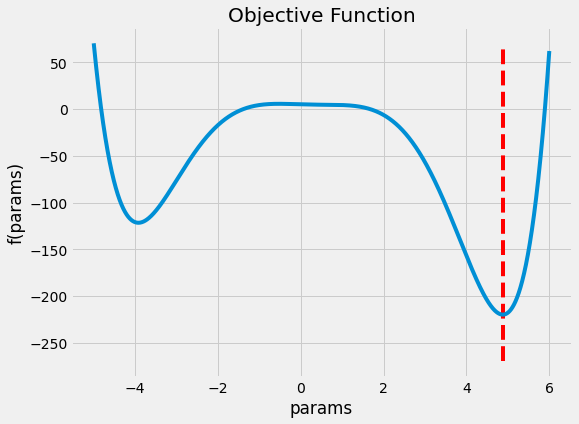

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Space over which to evluate the function is -5 to 6
x = np.linspace(-5, 6, 10000)
y = objective(x)

miny = min(y)
minx = x[np.argmin(y)]

# Visualize the function
plt.figure(figsize = (8, 6))
plt.style.use('fivethirtyeight')
plt.title('Objective Function'); plt.xlabel('params'); plt.ylabel('f(params)')
plt.vlines(minx, min(y)- 50, max(y), linestyles = '--', colors = 'r')
plt.plot(x, y);

# Print out the minimum of the function and value
print('Minimum of %0.4f occurs at %0.4f' % (miny, minx))

### Domain


The domain is the values of ***params*** over which we evaluate the function. First we can use a uniform distribution over the space our function is defined.

Search space is where Hyperopt really gives you a ton of sampling options:
* for categorical parameters you have hp.choice
* for integers you get hp.randit, hp.quniform, hp.qloguniform and hp.qlognormal
* for floats we have hp.normal,  hp.uniform, hp.lognormal and hp.loguniform​

In [7]:
from hyperopt import hp

space = hp.uniform('x', -5, 6)

In [ ]:
#hyperspace for NN
space = {'choice': hp.choice('num_layers',
                    [ {'layers':'two', },
                      {'layers':'three',
                        'units3': hp.uniform('units3', 64,1024), 
                        'dropout3': hp.uniform('dropout3', .25,.75)}
                    ]),

            'units1': hp.uniform('units1', 64, 1024),
            'units2': hp.uniform('units2', 64, 1024),

            'dropout1': hp.uniform('dropout1', .25,.75),
            'dropout2': hp.uniform('dropout2',  .25,.75),

            'batch_size' : hp.uniform('batch_size', 28,128),

            'nb_epochs' :  100,
            'optimizer': hp.choice('optimizer',['adadelta','adam','rmsprop']),
            'activation': 'relu'
        }

# Hyperparameter Optimization Algorithm

There are two choices for a hyperparameter optimization algorithm in Hyperopt: random and Tree Parzen Estimator. We can use both and compare the results. Using the suggest algorithm in these families automatically configures the algorithm for us.

In [8]:
from hyperopt import rand, tpe

# Create the algorithms
tpe_algo = tpe.suggest
rand_algo = rand.suggest

### History runs
Storing the history is as simple as making a Trials object that we pass into the function call. This is not strictly necessary, but it gives us information that we can use to understand what the algorithm is doing.

In [9]:
from hyperopt import Trials

# Create two trials objects
tpe_trials = Trials()
rand_trials = Trials()


### Run the Optimization 


In [10]:
from hyperopt import fmin

# Run 2000 evals with the tpe algorithm
tpe_best = fmin(fn=objective, space=space, algo=tpe_algo, trials=tpe_trials, 
                max_evals=2000, rstate= np.random.RandomState(50))

print(tpe_best)

# Run 2000 evals with the random algorithm
rand_best = fmin(fn=objective, space=space, algo=rand_algo, trials=rand_trials, 
                 max_evals=2000, rstate= np.random.RandomState(50))
print(rand_best)

100%|██████████| 2000/2000 [00:16<00:00, 121.23trial/s, best loss: -219.80118811219114]
{'x': 4.878481851906148}
100%|██████████| 2000/2000 [00:03<00:00, 530.89trial/s, best loss: -219.80116907646868]
{'x': 4.877613189834774}


In [11]:
# Print out information about losses
print('Minimum loss attained with TPE:    {:.4f}'.format(tpe_trials.best_trial['result']['loss']))
print('Minimum loss attained with random: {:.4f}'.format(rand_trials.best_trial['result']['loss']))
print('Actual minimum of f(x):            {:.4f}'.format(miny))

# Print out information about number of trials
print('\nNumber of trials needed to attain minimum with TPE:    {}'.format(tpe_trials.best_trial['misc']['idxs']['x'][0]))
print('Number of trials needed to attain minimum with random: {}'.format(rand_trials.best_trial['misc']['idxs']['x'][0]))

# Print out information about value of x
print('\nBest value of x from TPE:    {:.4f}'.format(tpe_best['x']))
print('Best value of x from random: {:.4f}'.format(rand_best['x']))
print('Actual best value of x:      {:.4f}'.format(minx))

Minimum loss attained with TPE:    -219.8012
Minimum loss attained with random: -219.8012
Actual minimum of f(x):            -219.8012

Number of trials needed to attain minimum with TPE:    655
Number of trials needed to attain minimum with random: 235

Best value of x from TPE:    4.8785
Best value of x from random: 4.8776
Actual best value of x:      4.8779
